# Let's build a simple numpy-based NN to classify MNIST

### Upload the dataset

In [23]:
import torchvision.datasets as dsets
import numpy as np

#TODO use raw mnist data no torch modules
mnist_train = dsets.MNIST(root='./mnist', download=True)
x_train = np.array(mnist_train.data)
y_train = np.array(mnist_train.targets)

mnist_test = dsets.MNIST(root='./mnist', train=False, download=True)
x_test = np.array(mnist_test.data)
y_test = np.array(mnist_test.targets)

In [28]:
assert x_train.shape[0] ==  y_train.shape[0]
assert x_test.shape[0] ==  y_test.shape[0]

### Weight Initialization
The outputs from a randomly initialized neuron has a variance that grows with the number of inputs. It turns out that we can normalize the variance of each neuron’s output to $ 1 $ by scaling its weight vector by the square root of its fan-in (i.e. its number of inputs). That is, the recommended heuristic is to initialize each neuron’s weight vector as: w = np.random.randn(n) / sqrt(n), where $ n $ is the number of its inputs. This ensures that all neurons in the network initially have approximately the same output distribution and empirically improves the rate of convergence.

The sketch of the derivation is as follows: Consider the inner product $ s = \sum_i^n w_i x_i $ between the weights $ w $ and input $ x $, which gives the raw activation of a neuron before the non-linearity. We can examine the variance of $ s $:

where in the first 2 steps we have used properties of variance. In third step we assumed zero mean inputs and weights, so $ E[x_i] = E[w_i] = 0 $. Note that this is not generally the case: For example ReLU units will have a positive mean. In the last step we assumed that all $ w_i $, $ x_i $ are identically distributed. From this derivation we can see that if we want s to have the same variance as all of its inputs $ x $, then during initialization we should make sure that the variance of every weight $ w $ is $ 1/n $. And since $ \text{Var}(aX) = a^2\text{Var}(X) $ for a random variable $ X $ and a scalar $ a $, this implies that we should draw from unit gaussian and then scale it by $ a = \sqrt{1/n} $, to make its variance $ 1/n $. This gives the initialization w = np.random.randn(n) / sqrt(n).

In [38]:
classes = 10
input_n = 784 # (28 x 28)
hidden_n = 64

params = {"W1": np.random.randn(hidden_n, input_n) * np.sqrt(1. / input_n),
          "b1": np.zeros((hidden_n, 1)) * np.sqrt(1. / input_n),
          "W2": np.random.randn(classes, hidden_n) * np.sqrt(1. / hidden_n),
          "b2": np.zeros((classes, 1)) * np.sqrt(1. / hidden_n)}

### Activation Functions
The sigmoid function gives an ‘S’ shaped curve. This curve has a finite limit of:

‘0’ as $ x $ approaches $ - \infty $
‘1’ as $ x $ approaches $ + \infty $

In [33]:
def sigmoid(z):
    s = 1. / (1. + np.exp(-z))
    return s

def softmax(z):
    return np.exp(z) / np.sum(np.exp(z), axis=0, keepdims=True)

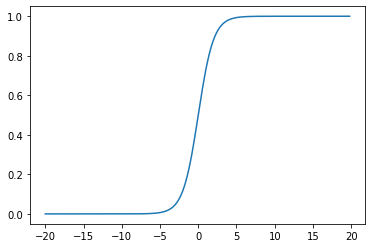

In [32]:
import matplotlib.pyplot as plt
x = np.arange(-20., 20., 0.2)
y = sigmoid(x)
plt.plot(x, y)

### Loss Function
What we use in this example is cross-entropy loss.
After averaging over a training set of $ m $ examples.

In [ ]:
def loss(Y, Y_hat):
    L_sum = np.sum(np.multiply(Y, np.log(Y_hat)))
    m = Y.shape[1]
    L = -(1./m) * L_sum

    return L

### Training step, Forward pass and back propagation

#### Forward pass
The forward pass on a single example $x$ executes the following computation on each layer of Neural Networks:

In [34]:
def feed_forward(X, params):
    """
    feed forward network: 2layer neural net
    inputs:
        params: dictionay a dictionary contains all the weights and biases
    return:
        cache: dictionay a dictionary contains all the fully connected units and activations
    """
    cache = {}

    # Z1 = W1.dot(x) + b1
    cache["Z1"] = np.matmul(params["W1"], X) + params["b1"]

    # A1 = sigmoid(Z1)
    cache["A1"] = sigmoid(cache["Z1"])

    # Z2 = W2.dot(A1) + b2
    cache["Z2"] = np.matmul(params["W2"], cache["A1"]) + params["b2"]

    # A2 = softmax(Z2)
    cache["A2"] = softmax(cache["Z2"]) # np.exp() / np.sum(np.exp(cache["Z2"]), axis=0)

    return cache

#### Back Propagation
For backpropagation, we’ll need to know how loss changes with respect to each component $w_j$ of $w$. 
That is, we must compute each $ \frac{\partial L}{\partial w_j} $.

Back propagation is actually a fancy name of chain rules. 

Let us focusing on $ \frac{\partial L}{\partial \hat{y}} $ first:
TODO ADDD

By the chain rule, we can get:
TODO ADDD


In [ ]:
def back_propagate(X, Y, params, cache, m_batch):
    """
    back propagation

    inputs:
        params: dictionay a dictionary contains all the weights and biases
        cache: dictionay a dictionary contains all the fully connected units and activations

    return:
        grads: dictionay a dictionary contains the gradients of corresponding weights and biases
    """
    # error at last layer
    dZ2 = cache["A2"] - Y

    # gradients at last layer (Py2 need 1. to transform to float)
    dW2 = (1. / m_batch) * np.matmul(dZ2, cache["A1"].T)
    db2 = (1. / m_batch) * np.sum(dZ2, axis=1, keepdims=True)

    # back propgate through first layer
    dA1 = np.matmul(params["W2"].T, dZ2)
    dZ1 = dA1 * sigmoid(cache["Z1"]) * (1 - sigmoid(cache["Z1"]))

    # gradients at first layer (Py2 need 1. to transform to float)
    dW1 = (1. / m_batch) * np.matmul(dZ1, X.T)
    db1 = (1. / m_batch) * np.sum(dZ1, axis=1, keepdims=True)

    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}

    return grads

#### Training and Hyper parameter setup
Training process can be simplified as a loop forward pass -> compute loss -> back propagation -> update weights and bias -> forward pass

In [39]:
momentum = 0.9
batch_size = 64
epochs = 100
lr = 0.001

In [ ]:
for i in range(epochs):

    # shuffle training set
    permutation = np.random.permutation(X_train.shape[1])
    X_train_shuffled = X_train[:, permutation]
    Y_train_shuffled = Y_train[:, permutation]

    for j in range(batches):
        # get mini-batch
        begin = j * batch_size
        end = min(begin + batch_size, X_train.shape[1] - 1)
        X = X_train_shuffled[:, begin:end]
        Y = Y_train_shuffled[:, begin:end]
        m_batch = end - begin

        # forward and backward
        cache = feed_forward(X, params)
        grads = back_propagate(X, Y, params, cache, m_batch)

        # with momentum 
        dW1 = (momentum * dW1 + (1. - momentum) * grads["dW1"])
        db1 = (momentum * db1 + (1. - momentum) * grads["db1"])
        dW2 = (momentum * dW2 + (1. - momentum) * grads["dW2"])
        db2 = (momentum * db2 + (1. - momentum) * grads["db2"])

        # gradient descent
        params["W1"] = params["W1"] - lr * dW1
        params["b1"] = params["b1"] - lr * db1
        params["W2"] = params["W2"] - lr * dW2
        params["b2"] = params["b2"] - lr * db2

    # forward pass on training set
    cache = feed_forward(X_train, params)
    train_loss = loss(Y_train, cache["A2"])

    # forward pass on test set
    cache = feed_forward(X_test, params)
    test_loss = loss(Y_test, cache["A2"])
    print("Epoch {}: training loss = {}, test loss = {}".format(
        i + 1, train_loss, test_loss))

### Evaluation

### References
- [Towards datascience post](https://towardsdatascience.com/building-an-artificial-neural-network-using-pure-numpy-3fe21acc5815)
- [Neural net from scratch](https://zhenye-na.github.io/2018/09/09/build-neural-network-with-mnist-from-scratch.html)
- [How backpropagation works](http://neuralnetworksanddeeplearning.com/chap2.html)